# 0. Import Libraries

In [205]:
# Import necessary libraries for data manipulation, visualization, statistical analysis and machine learning

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc as pm
from scipy.stats import beta

from tabulate import tabulate
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [4]:
# Setting for ease of reading display numbers

pd.options.display.float_format = '{:20.2f}'.format

# Show all columns on output

pd.set_option('display.max_columns', 999)

# 1. Import Data

In [6]:
# Load the dataset from a CSV file

df = pd.read_csv('../Datasets/ECommerce_Promotions_ABTest.csv')

tp = pd.read_csv('../Published Files/Top5_Products.csv')
tc = pd.read_csv('../Published Files/Top20_Customers.csv')

# Display the first 10 rows to confirm data availability

df.head(10)

,CustomerID,ProductID,EmailSubject,DiscountType,UrgencyMessage,EmailOpened,Clicked,Converted,CommunicationChannel
0,cust755,6534178,Exclusive Deal for You!,Flat,Limited Time Only!,0,0,1,Email
1,cust755,1082185,Exclusive Deal for You!,Percentage,Limited Time Only!,1,1,1,SMS
2,cust755,1029743,Your Favorite Product is On Sale!,Flat,No Urgency,1,0,0,Email
3,cust755,6533889,Your Favorite Product is On Sale!,Flat,Limited Time Only!,1,0,0,SMS
4,cust755,951590,Your Favorite Product is On Sale!,Flat,No Urgency,0,0,0,SMS
5,cust1023,6534178,Your Favorite Product is On Sale!,Flat,Limited Time Only!,0,0,0,Email
6,cust1023,1082185,Your Favorite Product is On Sale!,Percentage,No Urgency,1,0,0,SMS
7,cust1023,1029743,Your Favorite Product is On Sale!,Percentage,No Urgency,0,0,0,SMS
8,cust1023,6533889,Your Favorite Product is On Sale!,Flat,No Urgency,1,0,0,SMS
9,cust1023,951590,Exclusive Deal for You!,Percentage,No Urgency,1,1,1,SMS


# 2. Data Exploration

In [8]:
# Show columns, data types, and nulls to prepare hygiene activities

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285100 entries, 0 to 285099
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CustomerID            285100 non-null  object
 1   ProductID             285100 non-null  int64 
 2   EmailSubject          285100 non-null  object
 3   DiscountType          285100 non-null  object
 4   UrgencyMessage        285100 non-null  object
 5   EmailOpened           285100 non-null  int64 
 6   Clicked               285100 non-null  int64 
 7   Converted             285100 non-null  int64 
 8   CommunicationChannel  285100 non-null  object
dtypes: int64(4), object(5)
memory usage: 19.6+ MB


In [9]:
# Show descriptive statistics for columns

df.describe()

,ProductID,EmailOpened,Clicked,Converted
count,285100.00,285100.00,285100.00,285100.00
mean,3956281.07,0.75,0.37,0.26
std,1878604.10,0.58,0.51,0.44
min,951590.00,0.00,0.00,0.00
25%,2528871.00,0.00,0.00,0.00
50%,3916780.00,1.00,0.00,0.00
75%,5529857.00,1.00,1.00,1.00
max,6984533.00,4.00,2.00,1.00


In [10]:
# Show descriptive statistics for object columns

df.describe(include='O')

,CustomerID,EmailSubject,DiscountType,UrgencyMessage,CommunicationChannel
count,285100,285100,285100,285100,285100
unique,4771,2,2,2,2
top,cust58,Your Favorite Product is On Sale!,Percentage,No Urgency,Email
freq,538,142871,142620,142952,142608


In [11]:
# Check for missing or inconsistent values

print(df['CustomerID'].isnull().sum())
print(df['ProductID'].isnull().sum())

0
0


# 3. Feature Engineering

In [13]:
# Convert CustomerID and ProductID into lists

top_20_customers = tc['CustomerID'].tolist()

top_5_products = tp['ProductID'].tolist()

In [14]:
# Categorize CustomerID as 'Top20' or 'Non-Top20' and ProductID as 'Top5' or 'Non-Top5'

df['CustomerType'] = df['CustomerID'].apply(lambda x: 'Top20' if x in top_20_customers else 'Non-Top20')

df['ProductType'] = df['ProductID'].apply(lambda x: 'Top5' if x in top_5_products else 'Non-Top5')

# Concatenate the CustomerID and ProductID categories into one feature

df['Segment'] = df['CustomerType'] + "_" + df['ProductType']

In [15]:
# Evaluate Segment for distribution to prevent skewness in mmodeling

df['Segment'].value_counts()

Segment
Non-Top20_Non-Top5    255003
Non-Top20_Top5         20012
Top20_Top5              5423
Top20_Non-Top5          4662
Name: count, dtype: int64

In [16]:
# Display the first 10 rows to confirm data shows as expected

df.head(10)

,CustomerID,ProductID,EmailSubject,DiscountType,UrgencyMessage,EmailOpened,Clicked,Converted,CommunicationChannel,CustomerType,ProductType,Segment
0,cust755,6534178,Exclusive Deal for You!,Flat,Limited Time Only!,0,0,1,Email,Top20,Top5,Top20_Top5
1,cust755,1082185,Exclusive Deal for You!,Percentage,Limited Time Only!,1,1,1,SMS,Top20,Top5,Top20_Top5
2,cust755,1029743,Your Favorite Product is On Sale!,Flat,No Urgency,1,0,0,Email,Top20,Top5,Top20_Top5
3,cust755,6533889,Your Favorite Product is On Sale!,Flat,Limited Time Only!,1,0,0,SMS,Top20,Top5,Top20_Top5
4,cust755,951590,Your Favorite Product is On Sale!,Flat,No Urgency,0,0,0,SMS,Top20,Non-Top5,Top20_Non-Top5
5,cust1023,6534178,Your Favorite Product is On Sale!,Flat,Limited Time Only!,0,0,0,Email,Top20,Top5,Top20_Top5
6,cust1023,1082185,Your Favorite Product is On Sale!,Percentage,No Urgency,1,0,0,SMS,Top20,Top5,Top20_Top5
7,cust1023,1029743,Your Favorite Product is On Sale!,Percentage,No Urgency,0,0,0,SMS,Top20,Top5,Top20_Top5
8,cust1023,6533889,Your Favorite Product is On Sale!,Flat,No Urgency,1,0,0,SMS,Top20,Top5,Top20_Top5
9,cust1023,951590,Exclusive Deal for You!,Percentage,No Urgency,1,1,1,SMS,Top20,Non-Top5,Top20_Non-Top5


In [17]:
# Calculate Open Rate = Number of emails opened by the customer, divided by the total emails sent to the customer

df['OpenRate'] = df['EmailOpened'] / df.groupby('CustomerID')['EmailOpened'].transform('sum')

# Calculate Click-thru Rate = Number of emails clicked, divided by the total number of emails opened

df['ClickThruRate'] = df['Clicked'] / df['EmailOpened']

# Calculate Converstion Rate = Number of clicks that have results in sales (Converted), divided by the total number of clicks

df['ConversionRate'] = df['Converted'] / df['Clicked']

# Set missing values to 0

df.fillna({'ClickThruRate': 0, 'ConversionRate': 0}, inplace = True)

In [18]:
print(df['OpenRate'], df['ClickThruRate'], df['ConversionRate'])

0                        0.00
1                        0.00
2                        0.00
3                        0.00
4                        0.00
                 ...         
285095                   0.00
285096                   0.00
285097                   0.00
285098                   0.00
285099                   0.00
Name: OpenRate, Length: 285100, dtype: float64 0                        0.00
1                        1.00
2                        0.00
3                        0.00
4                        0.00
                 ...         
285095                   0.25
285096                    inf
285097                   0.33
285098                   0.00
285099                    inf
Name: ClickThruRate, Length: 285100, dtype: float64 0                         inf
1                        1.00
2                        0.00
3                        0.00
4                        0.00
                 ...         
285095                   1.00
285096                   0.00
2

In [19]:
# Set columns DiscountType, UrgencyMessage, CommunicationChannel, and Segment as a category

df['DiscountType'] = df['DiscountType'].astype('category')
df['UrgencyMessage'] = df['UrgencyMessage'].astype('category')
df['CommunicationChannel'] = df['CommunicationChannel'].astype('category')
df['Segment'] = df['Segment'].astype('category')

# 4. Modeling

## ANOVA

In [115]:
# Set the formula for the ANOVA model with Converted as the dependent variable and DiscountType, UrgencyMessage, CommunicationChannel, and Segment as independent variables; allow for multiplicative interaction

formula = "Converted ~ C(EmailSubject) * C(DiscountType) * C(UrgencyMessage) * C(CommunicationChannel) * C(Segment)"

In [117]:
# Define and perform the ANOVA model to test signifcance of the defined variables

anova_model = smf.ols(formula, data = df).fit()
anova_results = sm.stats.anova_lm(anova_model, typ = 2)

In [118]:
# Display the ANOVA model results

print(tabulate(anova_results, headers = 'keys', tablefmt = 'plain'))

                                                                                               sum_sq      df               F       PR(>F)
C(EmailSubject)                                                                           0.793033          1     4.23437        0.0396142
C(DiscountType)                                                                           0.218497          1     1.16665        0.280091
C(UrgencyMessage)                                                                         0.0759886         1     0.405738       0.524141
C(CommunicationChannel)                                                                   0.0032772         1     0.0174985      0.894761
C(Segment)                                                                             1255.24              3  2234.11           0
C(EmailSubject):C(DiscountType)                                                           0.000213623       1     0.00114063     0.973058
C(EmailSubject):C(UrgencyMessage)      

In [125]:
# Calculate conversion rates by Segment and display the results

segment_conversion = df.groupby('Segment')['Converted'].mean().reset_index()

print(tabulate(segment_conversion, headers = 'keys', tablefmt = 'plain'))


    Segment               Converted
 0  Non-Top20_Non-Top5     0.245766
 1  Non-Top20_Top5         0.246402
 2  Top20_Non-Top5         0.605749
 3  Top20_Top5             0.604462


C:\Users\halli\AppData\Local\Temp\ipykernel_80152\2202536893.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_conversion = df.groupby('Segment')['Converted'].mean().reset_index()


In [147]:
# Calculate conversion rates for the defined variables as groups and dsiplay the results

segment_all = df.groupby(['Segment','EmailSubject','DiscountType','UrgencyMessage','CommunicationChannel'])['Converted'].mean().reset_index()
segment_subject = df.groupby(['Segment','EmailSubject'])['Converted'].mean().reset_index()
segment_discount = df.groupby(['Segment','DiscountType'])['Converted'].mean().reset_index()
segment_urgency = df.groupby(['Segment','UrgencyMessage'])['Converted'].mean().reset_index()
segment_communication = df.groupby(['Segment','CommunicationChannel'])['Converted'].mean().reset_index()
discount_urgency_communication = df.groupby(['DiscountType','UrgencyMessage','CommunicationChannel'])['Converted'].mean().reset_index()

print(tabulate(segment_all, headers = 'keys', tablefmt = 'plain'))
print(tabulate(segment_subject, headers = 'keys', tablefmt = 'plain'))
print(tabulate(segment_discount, headers = 'keys', tablefmt = 'plain'))
print(tabulate(segment_urgency, headers = 'keys', tablefmt = 'plain'))
print(tabulate(segment_communication, headers = 'keys', tablefmt = 'plain'))
print(tabulate(discount_urgency_communication, headers = 'keys', tablefmt = 'plain'))

C:\Users\halli\AppData\Local\Temp\ipykernel_80152\1977173801.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_all = df.groupby(['Segment','EmailSubject','DiscountType','UrgencyMessage','CommunicationChannel'])['Converted'].mean().reset_index()
C:\Users\halli\AppData\Local\Temp\ipykernel_80152\1977173801.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_subject = df.groupby(['Segment','EmailSubject'])['Converted'].mean().reset_index()
C:\Users\halli\AppData\Local\Temp\ipykernel_80152\1977173801.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in 

    Segment             EmailSubject                       DiscountType    UrgencyMessage      CommunicationChannel      Converted
 0  Non-Top20_Non-Top5  Exclusive Deal for You!            Flat            Limited Time Only!  Email                      0.245887
 1  Non-Top20_Non-Top5  Exclusive Deal for You!            Flat            Limited Time Only!  SMS                        0.246172
 2  Non-Top20_Non-Top5  Exclusive Deal for You!            Flat            No Urgency          Email                      0.247715
 3  Non-Top20_Non-Top5  Exclusive Deal for You!            Flat            No Urgency          SMS                        0.239508
 4  Non-Top20_Non-Top5  Exclusive Deal for You!            Percentage      Limited Time Only!  Email                      0.243593
 5  Non-Top20_Non-Top5  Exclusive Deal for You!            Percentage      Limited Time Only!  SMS                        0.242627
 6  Non-Top20_Non-Top5  Exclusive Deal for You!            Percentage      No Urgen

The only significant singular features are Segment and Email Subject. However, the interaction between DiscountType, UrgencyMessage, and CommunicationChannel is highly significant (p = 0.010), indicating their combined effect has more influence than an individual feature.

When reviewing Segment's conversion rates by group, the feature's significance is validated. Top-20 customers convert 60.57% for non-Top5 products and 60.45% for Top5 products, which Non-Top20 customers convert 24.57% of the time for non-Top5 products and 24.64% for Top5 products.

Particular combinations of the significant multi-variate (DiscountType, UrgencyMessage, and CommunicationChannel) perform better than others. Flat discounts with No Urgency sent via Email have the highest overall conversion rate (26.32%). For SMS, Percentage discounts with No Urgency sent via SMS have the highest conversion for the CommunicationChannel and the second highest overall converstion rate (25.98%).  

While UrgencyMessage is insignificant, No Urgency consistently performs slightly better than Urgency for all Segments.

Maximum conversion combination: (65.29%) Top20 customers purchasing Non-Top5 products, based on an SMS with the tagline "Your Favorite Product is On Sale!" containing a percentage discount without urgency in the messaging.
Minimum conversion combination: (22.55%) Non-Top20 customers purchasing Top5 products, based on an Email with the subject "Exclusive Deal for You!" and a percentage discount without urgency in the message.

## Logistic Regression

In [150]:
# Create interaction features for those that show some significance to test further

df['Segment_DiscountType'] = df['Segment'].astype(str) + '_' + df['DiscountType'].astype(str)
df['Segment_UrgencyMessage'] = df['Segment'].astype(str) + '_' + df['UrgencyMessage'].astype(str)
df['Segment_DiscountType_UrgencyMessage'] = df['Segment'].astype(str) + '_' + df['DiscountType'].astype(str) + '_' + df['UrgencyMessage'].astype(str)
df['DiscountType_UrgencyMessage_CommunicationChannel'] = df['DiscountType'].astype(str) + '_' + df['UrgencyMessage'].astype(str) + '_' + df['CommunicationChannel'].astype(str)

interactions = ['Segment_DiscountType','Segment_UrgencyMessage','Segment_DiscountType_UrgencyMessage','DiscountType_UrgencyMessage_CommunicationChannel']
df[interactions] = df[interactions].astype('category')

In [152]:
# Set the defined features and target of the Logistic Regression

log_features = ['Segment','EmailSubject','DiscountType','UrgencyMessage','CommunicationChannel','Segment_DiscountType','Segment_UrgencyMessage','Segment_DiscountType_UrgencyMessage','DiscountType_UrgencyMessage_CommunicationChannel']
log_target = 'Converted'

In [154]:
# Encode categorical variables for regression

encoder = OneHotEncoder(drop = 'first', sparse_output = False)
x_encoded = encoder.fit_transform(df[log_features])
x_encoded_df = pd.DataFrame(x_encoded, columns = encoder.get_feature_names_out(log_features))

In [156]:
# Define the target variable

y = df[log_target]

In [158]:
# Split the data into training and test sets

x_train, x_test, y_train, y_test = train_test_split(x_encoded_df, y, test_size = 0.2, random_state = 42, stratify = y)

In [160]:
# Train the Logistic Regression model

log_reg = LogisticRegression(max_iter = 2000)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=2000)

In [162]:
# Make predictions on the test set

y_pred = log_reg.predict(x_test)
y_pred_proba = log_reg.predict_proba(x_test)[:,1]

In [164]:
# Compute Accuracy - the overall correctness of predictions

accuracy = accuracy_score(y_test, y_pred)

# Generate a Confusion Matrix - the evaluation and precentages of true positives, true negatives, false positives, and false negatives

conf_matrix = confusion_matrix(y_test, y_pred)

# Generate a Classification Report - the evaluation and percentages of precision, recall, and F1-scores for each class

classification_rep = classification_report(y_test, y_pred)

# Compute ROC-AUC - the model's ability to distinguish between classes

roc_auc = roc_auc_score(y_test, y_pred_proba)

In [166]:
# Print results of the Accuracy computation, ROC-AUC computation, Confusion Matrix, and Classification Report. 

print(accuracy)
print(roc_auc)
print(conf_matrix)
print(classification_rep)

0.7486320589266924
0.5331100742765239
[[41478   801]
 [13532  1209]]
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     42279
           1       0.60      0.08      0.14     14741

    accuracy                           0.75     57020
   macro avg       0.68      0.53      0.50     57020
weighted avg       0.71      0.75      0.67     57020



In [168]:
# Extract feature names from the encoder

coefficients = pd.DataFrame({
    'Feature': encoder.get_feature_names_out(log_features),
    'Coefficient': log_reg.coef_[0]
})

# Compute the Odds Ratios (Exponentiate Coefficients)

coefficients['Odds_Ratio'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients.sort_values(by = 'Odds_Ratio', ascending = False)

coefficients

,Feature,Coefficient,Odds_Ratio
1,Segment_Top20_Non-Top5,0.59,1.80
2,Segment_Top20_Top5,0.58,1.79
17,Segment_UrgencyMessage_Top20_Non-Top5_Limited ...,0.36,1.43
12,Segment_DiscountType_Top20_Top5_Flat,0.35,1.42
19,Segment_UrgencyMessage_Top20_Top5_Limited Time...,0.33,1.40
10,Segment_DiscountType_Top20_Non-Top5_Flat,0.32,1.38
11,Segment_DiscountType_Top20_Non-Top5_Percentage,0.27,1.31
20,Segment_UrgencyMessage_Top20_Top5_No Urgency,0.25,1.28
28,Segment_DiscountType_UrgencyMessage_Top20_Non-...,0.24,1.27
13,Segment_DiscountType_Top20_Top5_Percentage,0.23,1.26


Accuracy is less than 75% (74.86%) and the model's ability to distinguish between customers who convert compared to those who don't convert is only 53.3%. 

These scores are much lower than recommended for use of this model. Improving performance through class balancing, or trying alternate regression models, is suggested. 

The good news: the Confusion Matrix shows that, while ROC-AUC is 53%, the False Positives - customers who were predicted to convert that did not - are the smallest group at 801 out of 57,020 (1.4%). 

The top predictors for conversion are the following: Top20 customers and Non-Top5 products (80%), Top20 customers and Top5 products (79%), Urgency messaging for Top20 customers (43%), Flat discounts for Top20 customers (42%), and Percentage discounts for Top20 customers (31%). 

Though EmailSubject was deemed significant, using the line "Your Favorite Product is On Sale!" only has a 2% higher likelihood of conversion.

Non-Top20 customers are slightly less likely to purchase Top5 products when there is no Urgency Message (-11%). Non-Top20 customers are less likely to purchase Non-Top5 products where the pricing is Percentage-based (-16%).

## Bayesian A/B Testing

In [42]:
# Set up prior distributions for testing

alpha_prior, beta_prior = 1,1

### Email Subject

In [176]:
# Summarize conversions for each DiscountType

conversion_summary = df.groupby('EmailSubject')['Converted'].agg(['sum','count'])

# Compute the Alpha and Beta parameters for the Beta distributions
# Alpha = Prior Successes + Observed Conversions
# Beta = Prior Failures + (Total Customers - Converted Customers)

conversion_summary['Alpha'] = alpha_prior + conversion_summary['sum']
conversion_summary['Beta'] = beta_prior + (conversion_summary['count'] - conversion_summary['sum'])

In [178]:
# Define the number of samples and generate posterior samples for the groups

n_samples = 10000
favorite_samples = stats.beta.rvs(conversion_summary.loc['Your Favorite Product is On Sale!','Alpha'],
                              conversion_summary.loc['Your Favorite Product is On Sale!','Beta'], size = n_samples)
exclusive_samples = stats.beta.rvs(conversion_summary.loc['Exclusive Deal for You!','Alpha'],
                                    conversion_summary.loc['Exclusive Deal for You!','Beta'], size = n_samples)

# Compute the probability that one group performs better than the other group

prob_percentage = (percentage_samples > flat_samples).mean()

In [180]:
# Create a set of result computations for the test

results = {
    "Your Favorite Product is On Sale!": favorite_samples.mean(),
    "Exclusive Deal for You!": exclusive_samples.mean(),
    "Your Favorite Product > Exclusive Deal": prob_percentage
}

print(results)

{'Your Favorite Product is On Sale!': 0.2602180006431976, 'Exclusive Deal for You!': 0.25683101340485426, 'Your Favorite Product > Exclusive Deal': 0.0927}


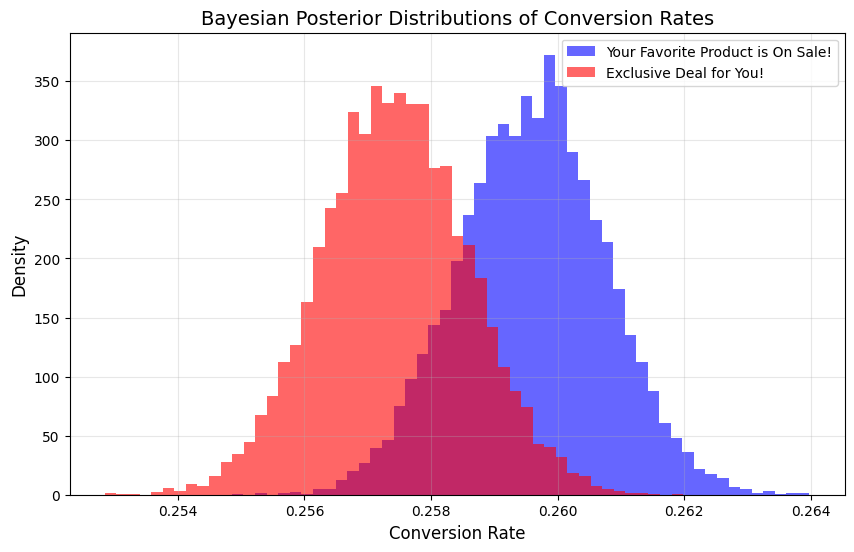

In [182]:
# Plot the posterior distributions

plt.figure(figsize=(10, 6))
plt.hist(flat_samples, bins=50, alpha=0.6, color='blue', density=True, label="Your Favorite Product is On Sale!")
plt.hist(percentage_samples, bins=50, alpha=0.6, color='red', density=True, label="Exclusive Deal for You!")

# Add labels and a legend

plt.xlabel("Conversion Rate", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Bayesian Posterior Distributions of Conversion Rates", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot

plt.show()

The probability that the Email Subject "Your Favorite Product is On Sale!" outperform "Exclusive Deal for You!" is 9.27%, with conversion rates of 26.02% for "Your Favorite Product is On Sale!" and 25.68% for "Exclusive Deal for You!".

While "Your Favorite Product is On Sale!" has consistently been deemed as favorable, there is no strong evidence to prioritize the use of one Email Subject over the other. 

### Discount Type

In [44]:
# Summarize conversions for each DiscountType

conversion_summary = df.groupby('DiscountType')['Converted'].agg(['sum','count'])

# Compute the Alpha and Beta parameters for the Beta distributions
# Alpha = Prior Successes + Observed Conversions
# Beta = Prior Failures + (Total Customers - Converted Customers)

conversion_summary['Alpha'] = alpha_prior + conversion_summary['sum']
conversion_summary['Beta'] = beta_prior + (conversion_summary['count'] - conversion_summary['sum'])

C:\Users\halli\AppData\Local\Temp\ipykernel_80152\2569096968.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_summary = df.groupby('DiscountType')['Converted'].agg(['sum','count'])


In [45]:
# Define the number of samples and generate posterior samples for the groups

n_samples = 10000
flat_samples = stats.beta.rvs(conversion_summary.loc['Flat','Alpha'],
                              conversion_summary.loc['Flat','Beta'], size = n_samples)
percentage_samples = stats.beta.rvs(conversion_summary.loc['Percentage','Alpha'],
                                    conversion_summary.loc['Percentage','Beta'], size = n_samples)

# Compute the probability that one group performs better than the other group

prob_percentage = (percentage_samples > flat_samples).mean()

In [46]:
# Create a set of result computations for the test

results = {
    "Flat Discount": flat_samples.mean(),
    "Percentage Discount": percentage_samples.mean(),
    "Probability Percentage Discount > Flat Discount": prob_percentage
}

print(results)

{'Flat Discount': 0.2595962653247063, 'Percentage Discount': 0.25743073590655385, 'Probability Percentage Discount > Flat Discount': 0.0927}


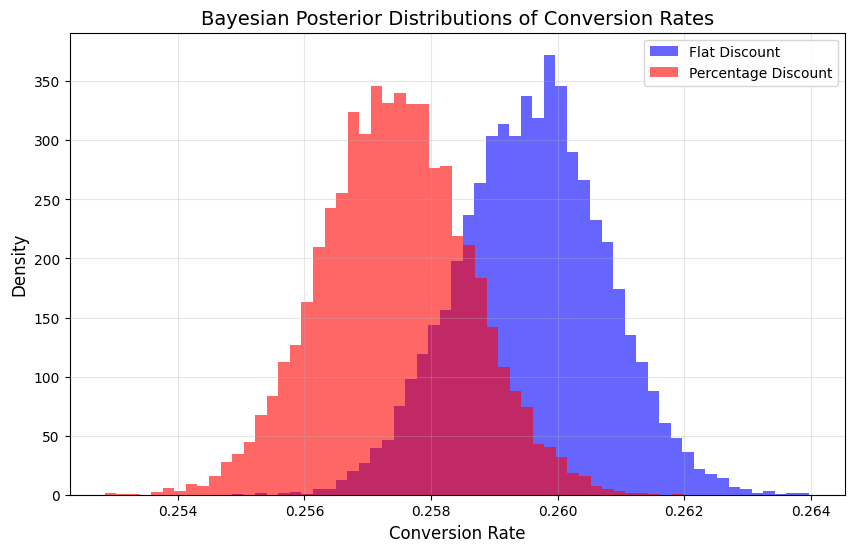

In [47]:
# Plot the posterior distributions

plt.figure(figsize=(10, 6))
plt.hist(flat_samples, bins=50, alpha=0.6, color='blue', density=True, label="Flat Discount")
plt.hist(percentage_samples, bins=50, alpha=0.6, color='red', density=True, label="Percentage Discount")

# Add labels and a legend

plt.xlabel("Conversion Rate", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Bayesian Posterior Distributions of Conversion Rates", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot

plt.show()

The probability that Percentage discounts outperform Flat discounts is 9.78%, with conversion rates of 25.96% for Flat discounts and 25.74% for Percentage discounts.

This confirms previous Logistic Regression findings, where Flat discounts had a Higher Odds ratio.

### Urgency Message

In [50]:
# Summarize conversions for each UrgencyMessage

conversion_summary = df.groupby('UrgencyMessage')['Converted'].agg(['sum','count'])

# Compute the Alpha and Beta parameters for the Beta distributions

conversion_summary['Alpha'] = alpha_prior + conversion_summary['sum']
conversion_summary['Beta'] = beta_prior + (conversion_summary['count'] - conversion_summary['sum'])

C:\Users\halli\AppData\Local\Temp\ipykernel_80152\3280357151.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_summary = df.groupby('UrgencyMessage')['Converted'].agg(['sum','count'])


In [51]:
# Define the number of samples and generate posterior samples for the groups

n_samples = 10000
lto_samples = stats.beta.rvs(conversion_summary.loc['Limited Time Only!','Alpha'],
                              conversion_summary.loc['Limited Time Only!','Beta'], size = n_samples)
none_samples = stats.beta.rvs(conversion_summary.loc['No Urgency','Alpha'],
                                    conversion_summary.loc['No Urgency','Beta'], size = n_samples)

# Compute the probability that one group performs better than the other group

prob_percentage = (lto_samples > none_samples).mean()

In [52]:
# Create a set of result computations for the test

results = {
    "Urgency": lto_samples.mean(),
    "No Urgency": none_samples.mean(),
    "Urgency > No Urgency": prob_percentage
}

print(results)

{'Urgency': 0.25811105045674554, 'No Urgency': 0.2589339217770579, 'Urgency > No Urgency': 0.3082}


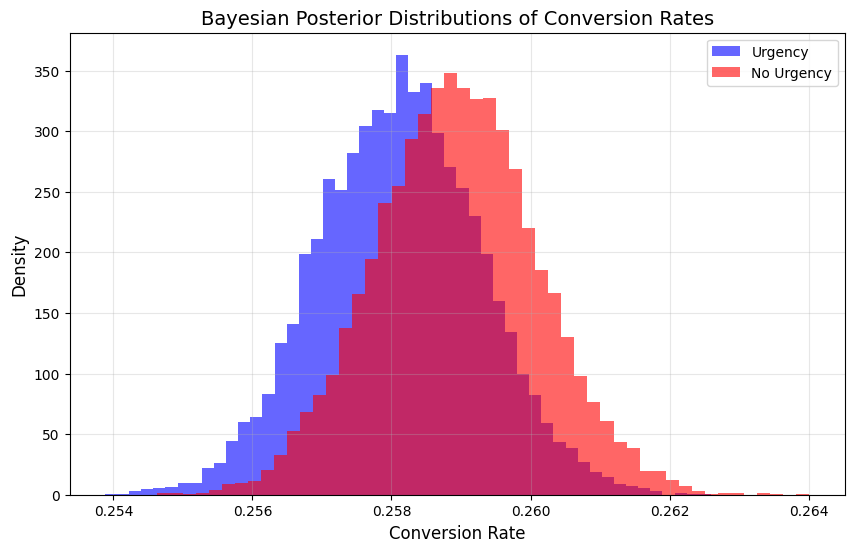

In [53]:
# Plot the posterior distributions

plt.figure(figsize=(10, 6))
plt.hist(lto_samples, bins=50, alpha=0.6, color='blue', density=True, label="Urgency")
plt.hist(none_samples, bins=50, alpha=0.6, color='red', density=True, label="No Urgency")

# Add labels and a legend

plt.xlabel("Conversion Rate", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Bayesian Posterior Distributions of Conversion Rates", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot

plt.show()

The probability that Urgency is better than No Urgency is 30.82%, which is not considered significant. No Urgency messaging converts at 25.81% while No Urgency messaging converts at 25.89%.

This is consistent with ANOVA and Logistic Regression results, which showed no significant effect of Urgency Messaging overall. 

### Communication Channels

In [56]:
# Summarize conversions for each CommunicationChannel

conversion_summary = df.groupby('CommunicationChannel')['Converted'].agg(['sum','count'])

# Compute the Alpha and Beta parameters for the Beta distributions

conversion_summary['Alpha'] = alpha_prior + conversion_summary['sum']
conversion_summary['Beta'] = beta_prior + (conversion_summary['count'] - conversion_summary['sum'])

C:\Users\halli\AppData\Local\Temp\ipykernel_80152\748980294.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_summary = df.groupby('CommunicationChannel')['Converted'].agg(['sum','count'])


In [57]:
# Define the number of samples and generate posterior samples for the groups

n_samples = 10000
email_samples = stats.beta.rvs(conversion_summary.loc['Email','Alpha'],
                              conversion_summary.loc['Email','Beta'], size = n_samples)
sms_samples = stats.beta.rvs(conversion_summary.loc['SMS','Alpha'],
                                    conversion_summary.loc['SMS','Beta'], size = n_samples)

# Compute the probability that one group performs better than the other group

prob_percentage = (email_samples > sms_samples).mean()

In [58]:
# Create a set of result computations for the test

results = {
    "Email": email_samples.mean(),
    "SMS": sms_samples.mean(),
    "Email > SMS": prob_percentage
}

print(results)

{'Email': 0.2581642312441676, 'SMS': 0.25885890171140236, 'Email > SMS': 0.3343}


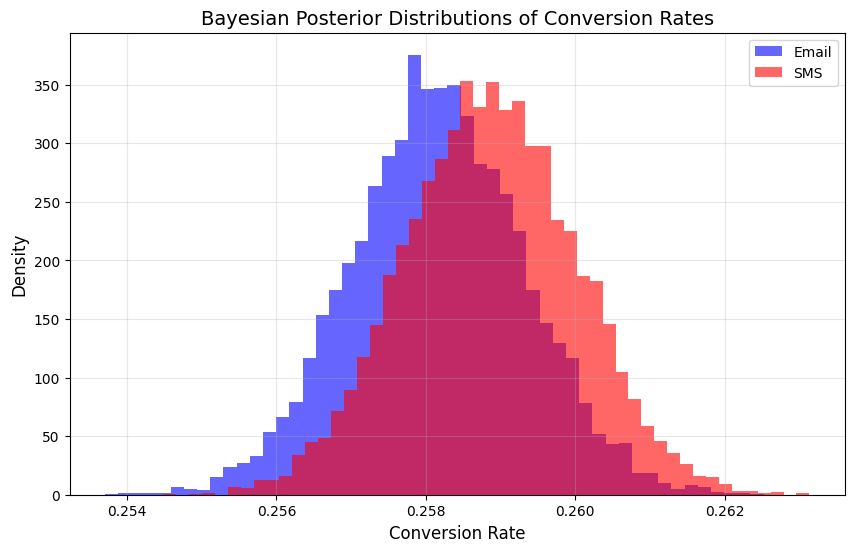

In [59]:
# Plot the posterior distributions

plt.figure(figsize=(10, 6))
plt.hist(email_samples, bins=50, alpha=0.6, color='blue', density=True, label="Email")
plt.hist(sms_samples, bins=50, alpha=0.6, color='red', density=True, label="SMS")

# Add labels and a legend

plt.xlabel("Conversion Rate", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Bayesian Posterior Distributions of Conversion Rates", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot

plt.show()

The probability that Email performs better than SMS is 33.59%, which is not considered significant. Email converts at 25.82% while SMS converts at 25.89%.

This aligns with Logistic Regression results, where SMS had a High Odds Ratio of 5% (1.05).

### Multi-Feature Interactions

In [211]:
# Create a set of multiplicative interaction groups

interaction_groups = [
    ('Segment','DiscountType'),
    ('Segment','UrgencyMessage'),
    ('CommunicationChannel','UrgencyMessage','DiscountType')
]

In [213]:
# Initiate a dictionary to store results

bayesian_interaction_results = {}

# Loop through each defined interaction group

for group in interaction_groups:
    group_name = " x ".join(group)
    conversion_summary = df.groupby(list(group))['Converted'].agg(['sum','count'])

    conversion_summary['Alpha'] = alpha_prior + conversion_summary['sum']
    conversion_summary['Beta'] = beta_prior + (conversion_summary['count'] - conversion_summary['sum'])

    interaction_samples = {
        key: stats.beta.rvs(row['Alpha'], row['Beta'], size = 10000)
        for key, row in conversion_summary.iterrows()
    }

    keys = list(interaction_samples.keys())
    pairwise_results = {}

    for key1, key2 in itertools.combinations(keys, 2):
        prob_key1_better = (interaction_samples[key1] > interaction_samples[key2]).mean()
        pairwise_results[f"Probability {key1} > {key2}"] = prob_key1_better

    bayesian_interaction_results[group_name] = {
        key: interaction_samples[key].mean() for key in keys
        }
    bayesian_interaction_results[group_name].update(pairwise_results)

C:\Users\halli\AppData\Local\Temp\ipykernel_80152\1151418115.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_summary = df.groupby(list(group))['Converted'].agg(['sum','count'])
C:\Users\halli\AppData\Local\Temp\ipykernel_80152\1151418115.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_summary = df.groupby(list(group))['Converted'].agg(['sum','count'])
C:\Users\halli\AppData\Local\Temp\ipykernel_80152\1151418115.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior 

In [215]:
# Loop through each test result in the results dictionary and print results for each group

for key, value in bayesian_interaction_results.items():
    print(f"\nInteraction Group: {key}")
    for k, v in value.items():
        print(f"{k}: {v: .1%}")


Interaction Group: Segment x DiscountType
('Non-Top20_Non-Top5', 'Flat'):  24.7%
('Non-Top20_Non-Top5', 'Percentage'):  24.4%
('Non-Top20_Top5', 'Flat'):  24.7%
('Non-Top20_Top5', 'Percentage'):  24.6%
('Top20_Non-Top5', 'Flat'):  59.3%
('Top20_Non-Top5', 'Percentage'):  61.8%
('Top20_Top5', 'Flat'):  60.0%
('Top20_Top5', 'Percentage'):  60.9%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Non-Top20_Non-Top5', 'Percentage'):  93.5%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Non-Top20_Top5', 'Flat'):  54.8%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Non-Top20_Top5', 'Percentage'):  55.7%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Top20_Non-Top5', 'Flat'):  0.0%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Top20_Non-Top5', 'Percentage'):  0.0%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Top20_Top5', 'Flat'):  0.0%
Probability ('Non-Top20_Non-Top5', 'Flat') > ('Top20_Top5', 'Percentage'):  0.0%
Probability ('Non-Top20_Non-Top5', 'Percentage') > ('Non-Top20_Top5', 'Flat')

The probability that Flat discounts work better than Percentage discounts for Non-Top20 customers to convert with Non-Top5 products is 93.5%. This confirms that Flat discounts should be prioritized for Non-Top20 customers. 

The combination of No Urgency with a Flat discount sent via Email is consistently the highest conversion rate and significantly high for probabilities.

The probability that Urgency Messaging performs better than No Urgency is 49.1%, meaning there is no significance. Urgency Messaging is, however, more significant for probability when it is included in SMS message and a Flat discount. 

For Top20 customers purchasing non-Top5 products, Percentage discounts have significant probability of conversion compared to Flat discounts. These customers also prefer No Urgency. Whereas, Non-Top20 customers prefer Flat discounts and Urgency messaging for non-Top5 products.

Top20 customers purchasing Top5 products react more favorably to Percentage discounts and No Urgency, while Non-Top20 customers have a higher probability of converting when presented Flat discounts with No Urgency.

# Summary and Next Steps

### Summary

- The strongest combination for conversion probability is No Urgency messaging with a Flat discount sent via Email. This, however, does not consider any differences in a customer's Segment.
- The highest overall probability of conversion, considering all features, is Top20 customers purchasing Non-Top5 products, based on an SMS with the tagline "Your Favorite Product is On Sale!" containing a Percentage discount without Urgency messaging.
- Flat discounts should be prioritized for non-Top20 customers while Percentage discounts for Top20 customers.
- Avoid Urgency messaging unless paired with SMS, preferably in combination with a Flat discount for best results.

### Next Steps

There are various opportunities for further utilizing these findings, optimizing strategies, and enhancing promotional capabilities. A few of these may include:

- Incorporate additional datasets to refine existing models and introduce advanced regression techniques like XGBoost and Random Forest to improve classification accuracy.
- Utilize Multi-Armed Bandit (MAB) algorithms to dynamically allocate promotional offers based on real-time performance, optimizing marketing spend and increasing conversion rates.
- Apply causal inference techniques to isolate the true effect of promotional experiments and refine future marketing investments.
- Assess the impact of different discount structures on demand by modeling price elasticity and customer response to pricing changes, ensuring optimal promotional effectiveness.
- Implement a Marketing Mix Model (MMM) to measure the effectiveness of marketing channels in driving conversions, predicting the impact of frequency and recency adjustments, and maximizing ROI.
- Further segment customers through predictive behavior analysis, leveraging hierarchical clustering and machine learning models to deliver hyper-personalized promotions.